In [1]:
import numpy as np
import xarray as xr
import calendar
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime
import paraguayfloodspy.visualize as viz # custom plotting library
from paraguayfloodspy.xrutil import *
%matplotlib inline

In [2]:
cmap_streamfunc = 'PuOr'
cmap_streamfunc_a = 'PuOr'
cmap_rain = 'Greens'
cmap_raina = 'BrBG'

In [3]:
rain_extent = [360-66, 360-49, -18, -39]
my_extent = [275, 330, 5, -37.5]

In [4]:
prcpa = xr.open_dataarray("../_data/rainfall/subset/cpc_anom.nc")
psi_200a = xr.open_dataarray("../_data/reanalysis/subset/streamfunc_200_anom.nc")
psi_850a = xr.open_dataarray("../_data/reanalysis/subset/streamfunc_850_anom.nc")

In [5]:
X, Y = np.meshgrid(psi_200a.lon, psi_200a.lat)
Xp, Yp = np.meshgrid(prcpa.lon, prcpa.lat)

In [6]:
months_plt = [11, 12, 1, 2]
month_names = ['November[0]', 'December[0]', 'Janurary[+]', 'February[+]']
ncols = len(months_plt)

In [7]:
savefigs = True

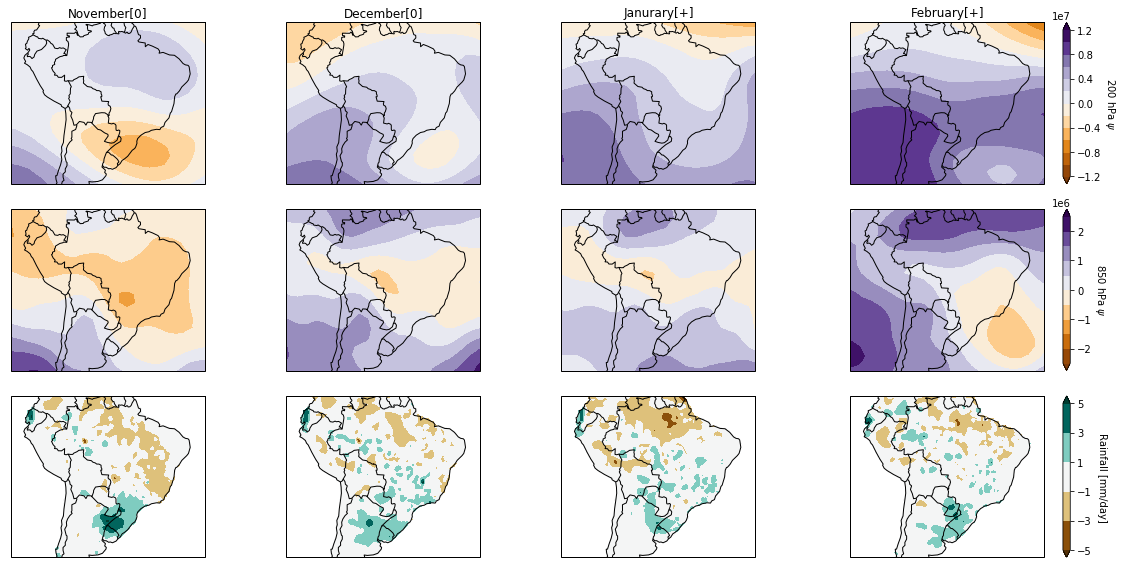

In [8]:
fig, axes = viz.SetupAxes(ncol = ncols, nax = 3 * ncols, proj = ccrs.Orthographic(-70, -10), figsize = [17, 8])
for i,m in enumerate(months_plt):
    def selector(ds):
        # see http://ggweather.com/enso/oni.htm
        enso_years = np.array([1982, 1997, 1986, 1987, 1991, 2002, 2009])
        enso_years = np.sort(enso_years)
        enso = xr.concat([ds.sel(time = slice(datetime.date(y, 11, 1), datetime.date(y+1, 2, 28))) for y in enso_years], dim='time')
        enso = enso.sel(time = (enso['time.month'] == m))
        return enso.mean(dim = 'time')

    # Row 1: 200 hPa wind
    ax = axes[0, i]
    ax.set_title('{}'.format(month_names[i]))
    C1 = ax.contourf(X, Y, selector(psi_200a), 
                     transform = ccrs.PlateCarree(),
                     cmap = cmap_streamfunc_a, 
                     levels = np.linspace(-1.2e7, 1.2e7, 13), 
                     extend = "both")
    if i == (ncols - 1):
        cbar1 = fig.colorbar(C1, ax = ax)
        cbar1.formatter.set_powerlimits((7, 7))
        cbar1.update_ticks()
        cbar1.set_label(r'200 hPa $\psi$', rotation=270)
        cbar1.ax.get_yaxis().labelpad = 15

    # Row 2: 850 hPa wind
    ax = axes[1, i]
    C2 = ax.contourf(X, Y, selector(psi_850a), 
                     transform = ccrs.PlateCarree(),
                     cmap = cmap_streamfunc_a, 
                     levels = np.linspace(-2.5e6, 2.5e6, 11), 
                     extend = "both")
    if i == (ncols - 1):
        cbar2 = fig.colorbar(C2, ax = ax)
        cbar2.formatter.set_powerlimits((7, 7))
        cbar2.update_ticks()
        cbar2.set_label(r'850 hPa $\psi$', rotation=270)
        cbar2.ax.get_yaxis().labelpad = 15

    # Row 3: Rainfall
    ax = axes[2, i]
    sub = selector(prcpa).values
    sub = np.ma.masked_invalid(sub)
    C3 = ax.contourf(Xp, Yp, sub, transform = ccrs.PlateCarree(), cmap = cmap_raina, 
                     levels = np.linspace(-5, 5, 6), extend = "both")
    if i == (ncols - 1):
        cbar3 = fig.colorbar(C3, ax = ax)
        cbar3.set_label('Rainfall [mm/day]', rotation=270)
        cbar3.ax.get_yaxis().labelpad = 15

viz.FormatAxes(axes[[0,1],:], coast=True, grid=False, border=True, river = False,
               feature_list = [], states=False, ticks=None, extent=my_extent)
viz.FormatAxes(axes[2,:], coast=True, grid=False, border=True, river = False,
               feature_list = [], states=False, extent = my_extent, ticks=None)

if savefigs:
    fig.savefig("../_figs/ENSOAnomalies.pdf", bbox_inches='tight')